In [1]:
import numpy as np
import pandas as pd
import shap
import lightgbm as lgb
import sklearn
from sklearn import linear_model
from sklearn.model_selection import train_test_split
import sklearn.preprocessing as preprocessing
import sklearn.metrics as metrics
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

/Users/leo/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/least_angle.py:30: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  method='lar', copy_X=True, eps=np.finfo(np.float).eps,
/Users/leo/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/least_angle.py:167: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  method='lar', 

### One-hot encoding

In [280]:
features = ["Age", "Workclass", "fnlwgt", "Education", "Education-Num", "Martial Status",
        "Occupation", "Relationship", "Race", "Sex", "Capital Gain", "Capital Loss",
        "Hours per week", "Country", "Target"] 

# Change these to local file if available
train_url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data'
test_url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.test'

# This will download 3.8M
original_train = pd.read_csv(train_url, names=features, sep=r'\s*,\s*', 
                             engine='python', na_values="?")
# This will download 1.9M
original_test = pd.read_csv(test_url, names=features, sep=r'\s*,\s*', 
                            engine='python', na_values="?", skiprows=1)

num_train = len(original_train)
original = pd.concat([original_train, original_test])
original = original.replace('Male', 1).replace('Female', 0)
roc_original = original
labels = original['Target']
labels = labels.replace('<=50K', 0).replace('>50K', 1)
labels = labels.replace('<=50K.', 0).replace('>50K.', 1)

In [281]:
print(len(original_train))
print(len(original_test))
original.head()

32561
16281


,Age,Workclass,fnlwgt,Education,Education-Num,Martial Status,Occupation,Relationship,Race,Sex,Capital Gain,Capital Loss,Hours per week,Country,Target
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,1,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,1,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,1,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,1,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,0,0,0,40,Cuba,<=50K


In [282]:
# Redundant column
del original["Education"]

# Remove target variable
del original["Target"]

def data_transform(df):
    """Normalize features."""
    binary_data = pd.get_dummies(df)
    feature_cols = binary_data[binary_data.columns[:-2]]
    scaler = preprocessing.StandardScaler()
    data = pd.DataFrame(scaler.fit_transform(feature_cols), columns=feature_cols.columns)
    return data

data = data_transform(original)
train_data = data[:num_train]
train_labels = labels[:num_train]
test_data = data[num_train:]
test_labels = labels[num_train:]

In [283]:
train_data.head()

,Age,fnlwgt,Education-Num,Sex,Capital Gain,Capital Loss,Hours per week,Workclass_Federal-gov,Workclass_Local-gov,Workclass_Never-worked,...,Country_Philippines,Country_Poland,Country_Portugal,Country_Puerto-Rico,Country_Scotland,Country_South,Country_Taiwan,Country_Thailand,Country_Trinadad&Tobago,Country_United-States
0,0.025996,-1.061979,1.136512,0.70422,0.146932,-0.217127,-0.034087,-0.173795,-0.26194,-0.01431,...,-0.077952,-0.042243,-0.037063,-0.061494,-0.02074,-0.048581,-0.036505,-0.024791,-0.023518,0.338083
1,0.828308,-1.007104,1.136512,0.70422,-0.144804,-0.217127,-2.213032,-0.173795,-0.26194,-0.01431,...,-0.077952,-0.042243,-0.037063,-0.061494,-0.02074,-0.048581,-0.036505,-0.024791,-0.023518,0.338083
2,-0.046942,0.246034,-0.419335,0.70422,-0.144804,-0.217127,-0.034087,-0.173795,-0.26194,-0.01431,...,-0.077952,-0.042243,-0.037063,-0.061494,-0.02074,-0.048581,-0.036505,-0.024791,-0.023518,0.338083
3,1.047121,0.426663,-1.197259,0.70422,-0.144804,-0.217127,-0.034087,-0.173795,-0.26194,-0.01431,...,-0.077952,-0.042243,-0.037063,-0.061494,-0.02074,-0.048581,-0.036505,-0.024791,-0.023518,0.338083
4,-0.776316,1.408530,1.136512,-1.42001,-0.144804,-0.217127,-0.034087,-0.173795,-0.26194,-0.01431,...,-0.077952,-0.042243,-0.037063,-0.061494,-0.02074,-0.048581,-0.036505,-0.024791,-0.023518,-2.957854


In [284]:
train_data.columns

Index(['Age', 'fnlwgt', 'Education-Num', 'Sex', 'Capital Gain', 'Capital Loss',
       'Hours per week', 'Workclass_Federal-gov', 'Workclass_Local-gov',
       'Workclass_Never-worked', 'Workclass_Private', 'Workclass_Self-emp-inc',
       'Workclass_Self-emp-not-inc', 'Workclass_State-gov',
       'Workclass_Without-pay', 'Martial Status_Divorced',
       'Martial Status_Married-AF-spouse', 'Martial Status_Married-civ-spouse',
       'Martial Status_Married-spouse-absent', 'Martial Status_Never-married',
       'Martial Status_Separated', 'Martial Status_Widowed',
       'Occupation_Adm-clerical', 'Occupation_Armed-Forces',
       'Occupation_Craft-repair', 'Occupation_Exec-managerial',
       'Occupation_Farming-fishing', 'Occupation_Handlers-cleaners',
       'Occupation_Machine-op-inspct', 'Occupation_Other-service',
       'Occupation_Priv-house-serv', 'Occupation_Prof-specialty',
       'Occupation_Protective-serv', 'Occupation_Sales',
       'Occupation_Tech-support', 'Occupatio

In [285]:
model = linear_model.LogisticRegression()
model.fit(train_data, train_labels)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [286]:
predictions = model.predict(test_data)
scores = model.predict_proba(test_data)[:, 1]
print('Accuracy:', np.mean(test_labels==predictions))

Accuracy: 0.8527117498925127


In [331]:
masker = shap.maskers.Independent(data = train_data)
explainer = shap.LinearExplainer(model, masker)
shap_values = explainer.shap_values(train_data)
ev = explainer.expected_value

# explainer = shap.KernelExplainer(model.predict_proba, shap.sample(train_data, 100), link='logit')
# shap_values = explainer.shap_values(shap.sample(test_data, 100))
# ev = explainer.expected_value

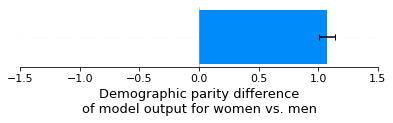

In [327]:
glabel = "Demographic parity difference\nof model output for women vs. men"
xmin = -1.5
xmax = 1.5
shap.group_difference_plot(shap_values.sum(1), original['Sex'][:num_train], xmin=xmin, xmax=xmax, xlabel=glabel)

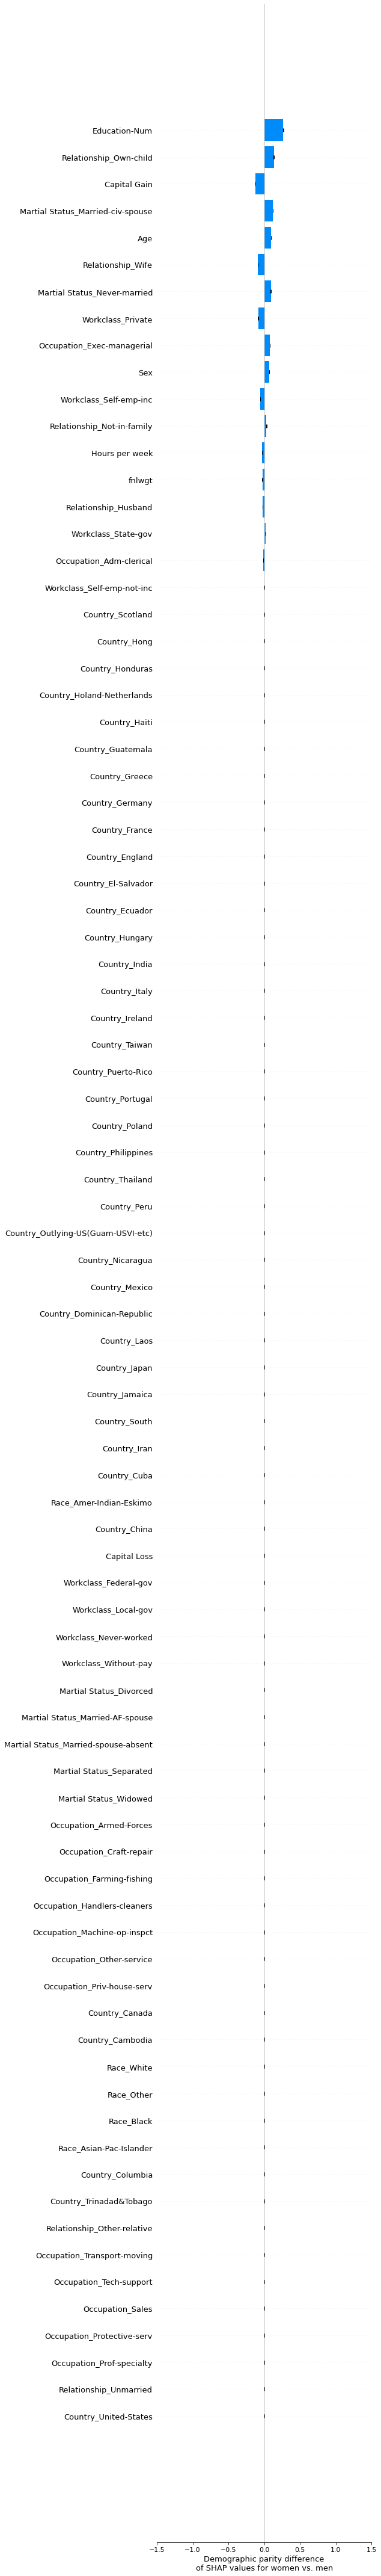

In [323]:
slabel = "Demographic parity difference\nof SHAP values for women vs. men"
shap.group_difference_plot(shap_values, original['Sex'], train_data.columns, xmin=xmin, xmax=xmax, xlabel=slabel)

### Ordinal encoding

In [364]:
X,y = shap.datasets.adult()
X_display,y_display = shap.datasets.adult(display=True)

# create a train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=7)
X_train.index = list(range(26048))
X_train.head()

,Age,Workclass,Education-Num,Marital Status,Occupation,Relationship,Race,Sex,Capital Gain,Capital Loss,Hours per week,Country
0,51.0,4,10.0,0,6,0,4,0,0.0,0.0,40.0,21
1,51.0,1,14.0,6,12,1,4,1,0.0,0.0,50.0,8
2,21.0,4,11.0,4,3,3,2,1,0.0,0.0,40.0,39
3,25.0,4,10.0,4,12,3,4,1,0.0,0.0,24.0,39
4,48.0,4,13.0,0,1,3,4,1,0.0,0.0,38.0,39


In [365]:
def data_transform(df, scale=True):
    """Normalize features."""
    cols = list(df.columns)
    del cols[7] # remove sex column
    feature_cols = df[cols]
    if scale:
        scaler = preprocessing.StandardScaler()
        data = pd.DataFrame(scaler.fit_transform(feature_cols), columns=feature_cols.columns)
    else:
        data = pd.DataFrame(df, columns=feature_cols.columns)
    return data

def data_transform_include_sex(df):
    """Normalize features."""
    cols = list(df.columns)
    feature_cols = df[cols]
    scaler = preprocessing.StandardScaler()
    data = pd.DataFrame(scaler.fit_transform(feature_cols), columns=feature_cols.columns)
    return data

train_data = data_transform(X_train, True)
train_labels = np.array(y_train, dtype='float')
test_data = data_transform(X_test, True)
test_labels = y_test
train_data_w_sex = data_transform_include_sex(X_train)

In [366]:
print(len(train_data))
print(len(test_data))
train_data.head()

26048
6513


,Age,Workclass,Education-Num,Marital Status,Occupation,Relationship,Race,Capital Gain,Capital Loss,Hours per week,Country
0,0.908061,0.088617,-0.032105,-1.734053,-0.135335,-1.416745,0.392878,-0.145096,-0.217383,-0.032682,-2.004859
1,0.908061,-1.974823,1.515106,2.247372,1.284596,-0.848161,0.392878,-0.145096,-0.217383,0.774235,-3.663500
2,-1.287692,0.088617,0.354698,0.920231,-0.845301,0.289007,-1.970012,-0.145096,-0.217383,-0.032682,0.291721
3,-0.994925,0.088617,-0.032105,0.920231,1.284596,0.289007,0.392878,-0.145096,-0.217383,-1.323748,0.291721
4,0.688485,0.088617,1.128304,-1.734053,-1.318612,0.289007,0.392878,-0.145096,-0.217383,-0.194065,0.291721


In [367]:
len(train_data.columns)

11

In [368]:
'''
Hyperparam tuning:
- max_iter [10,1000]
- penalty {l2, none}
- solver {liblinear, lbfgs}
- C [0.01, 10]
'''

model = linear_model.LogisticRegression(max_iter=100, penalty='l2', solver='lbfgs', C=0.1)
model.fit(train_data, train_labels)

LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [369]:
predictions = model.predict(test_data)
scores = model.predict_proba(test_data)[:, 1]
print('Accuracy:', np.mean(test_labels==predictions))

Accuracy: 0.8395516658989712


In [370]:
explainer = shap.Explainer(model, train_data)
shap_values = explainer.shap_values(train_data)
ev = explainer.expected_value
shap_values.shape

# explainer = shap.KernelExplainer(model.predict_proba, shap.sample(train_data, 100), link='logit')
# shap_values = explainer.shap_values(shap.sample(test_data, 100))
# ev = explainer.expected_value

(26048, 11)

In [371]:
female_indices = train_data_w_sex['Sex']<0
male_indices = train_data_w_sex['Sex']>0
print(np.mean(-np.log(1-model.predict_proba(train_data[female_indices])[:,1])))
print(np.mean(-np.log(1-model.predict_proba(train_data[male_indices])[:,1])))
print(np.mean(model.predict(train_data[female_indices])))
print(np.mean(model.predict(train_data[male_indices])))

0.287271903173395
0.7364927737867445
0.07720032554354145
0.22703043503181064


In [372]:
print(np.mean(shap_values[female_indices,:].sum(axis=1)))
print(np.mean(shap_values[male_indices,:].sum(axis=1)))

-0.48486848529110915
0.9033501335431846


In [401]:
np.mean(y_test)

0.23982803623522186

In [400]:
def sigmoid(x):
    return 1/(1+np.exp(-x))

def group_difference(output, idx_a, idx_b, labels, xmin, xmax, xlabel, apply_sigmoid=False):
    # compute confidence bounds for the group difference value
    vs = []
    gmean = np.mean(idx_b)
    for i in range(200):
        r = np.random.rand(output.shape[0]) > gmean
        vs.append(output[r].mean(0) - output[~r].mean(0))
    vs = np.array(vs)
    xerr = np.vstack([np.percentile(vs, 95, axis=0), np.percentile(vs, 5, axis=0)])

    # compute group difference value across two groups:
    a = np.mean(output[idx_a,:], axis=0)
    b = np.mean(output[idx_b,:], axis=0)
    if apply_sigmoid:
        diff = sigmoid(b) - sigmoid(a)
    else:
        diff = b-a
    sorted_idx = np.argsort(np.abs(diff)).astype(np.int)
    diff = diff[sorted_idx]
    xerr = xerr[:,sorted_idx]
    labels = labels[sorted_idx]
    if len(diff) == 1:
        print('diff:', np.round(diff[0], 3))
    
    # plot
    figsize = [6.4, 0.2 + 0.9 * len(labels)]
    plt.figure(figsize=figsize)
    ax = plt.gca()
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_visible(False)
    plt.barh(labels, 
             diff, 
             xerr=np.abs(xerr),
             capsize=3,
             color=shap.plots.colors.blue_rgb)
    plt.xlim((xmin, xmax))
    plt.xlabel(xlabel)
    plt.show()

diff: 0.331


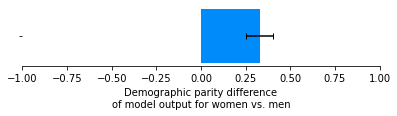

In [381]:
# shap_values (N * D) correspond to model logits; sigmoid(logits) = pred. logits = w1x1 + w2x2 +...
# s = sum(shap_values, axis=1) (N*1) <=> logits
# s_a for male indices; s_b for female indices
# sigmoid(mean(s_b)) - sigmoid(mean(s_a))


glabel = "Demographic parity difference\nof model output for women vs. men"
xmin = -1
xmax = 1
group_difference(shap_values.sum(axis=1, keepdims=True), 
                 female_indices, male_indices, 
                 np.array(['']),
                 xmin, xmax, glabel,
                 apply_sigmoid=True)

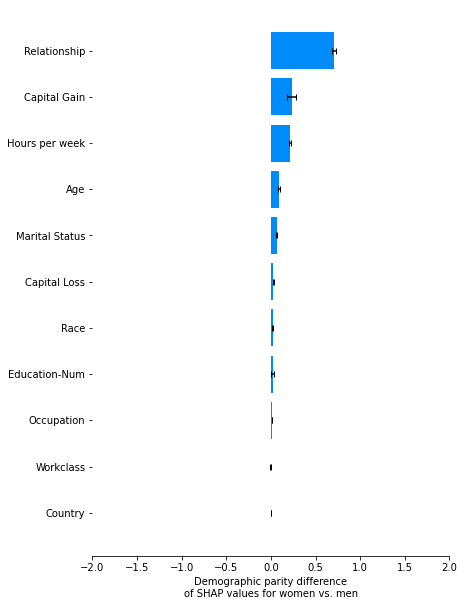

In [375]:
glabel = "Demographic parity difference\nof SHAP values for women vs. men"
xmin = -2
xmax = 2
group_difference(shap_values, 
                 female_indices, male_indices, 
                 train_data.columns,
                 xmin, xmax, glabel,
                 apply_sigmoid=False)

diff: 1.388


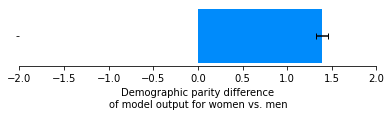

In [383]:
glabel = "Demographic parity difference\nof model output for women vs. men"
xmin = -2
xmax = 2
group_difference(shap_values.sum(axis=1, keepdims=True), 
                 female_indices, male_indices, 
                 np.array(['']),
                 xmin, xmax, glabel,
                 apply_sigmoid=False)

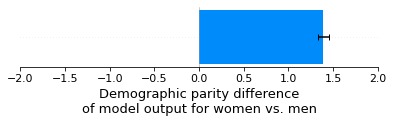

In [379]:
# package's function
glabel = "Demographic parity difference\nof model output for women vs. men"
xmin = -2
xmax = 2
shap.group_difference_plot(np.sum(shap_values, axis=1), male_indices, xmin=xmin, xmax=xmax, xlabel=glabel)

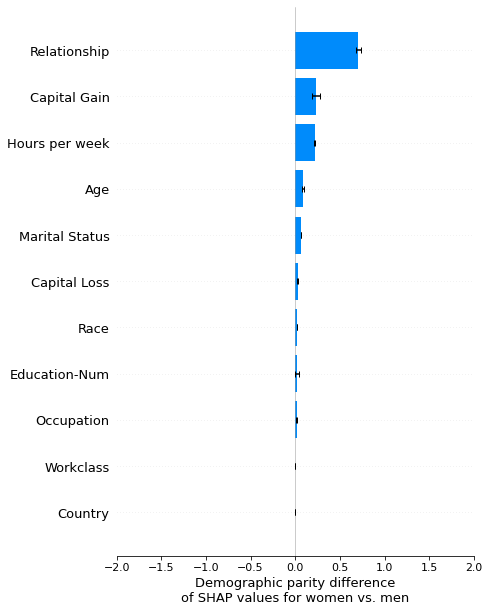

In [399]:
glabel = "Demographic parity difference\nof SHAP values for women vs. men"
shap.group_difference_plot(shap_values, male_indices, train_data.columns, xmin=xmin, xmax=xmax, xlabel=glabel)

Remove relationship column

In [355]:
def data_transform(df):
    """Normalize features."""
    cols = list(df.columns)
    del cols[7] # remove sex column
    del cols[5] # remove relationship column
    feature_cols = df[cols]
    scaler = preprocessing.StandardScaler()
    data = pd.DataFrame(scaler.fit_transform(feature_cols), columns=feature_cols.columns)
    return data

train_data = data_transform(X_train)
train_labels = y_train
test_data = data_transform(X_test)
test_labels = y_test

In [356]:
print(len(train_data))
print(len(test_data))
train_data.head()

26048
6513


,Age,Workclass,Education-Num,Marital Status,Occupation,Race,Capital Gain,Capital Loss,Hours per week,Country
0,0.908061,0.088617,-0.032105,-1.734053,-0.135335,0.392878,-0.145096,-0.217383,-0.032682,-2.004859
1,0.908061,-1.974823,1.515106,2.247372,1.284596,0.392878,-0.145096,-0.217383,0.774235,-3.663500
2,-1.287692,0.088617,0.354698,0.920231,-0.845301,-1.970012,-0.145096,-0.217383,-0.032682,0.291721
3,-0.994925,0.088617,-0.032105,0.920231,1.284596,0.392878,-0.145096,-0.217383,-1.323748,0.291721
4,0.688485,0.088617,1.128304,-1.734053,-1.318612,0.392878,-0.145096,-0.217383,-0.194065,0.291721


In [357]:
model = linear_model.LogisticRegression(max_iter=100, penalty='l2', solver='lbfgs', C=0.1)
model.fit(train_data, train_labels)
predictions = model.predict(test_data)
scores = model.predict_proba(test_data)[:, 1]
print('Accuracy:', np.mean(test_labels==predictions))

Accuracy: 0.8165208045447566


In [358]:
explainer = shap.Explainer(model, train_data)
shap_values = explainer.shap_values(train_data)
ev = explainer.expected_value

diff: 0.174


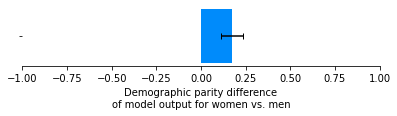

In [359]:
glabel = "Demographic parity difference\nof model output for women vs. men"
xmin = -1
xmax = 1
group_difference(shap_values.sum(axis=1, keepdims=True), 
                 female_indices, male_indices, 
                 np.array(['']),
                 xmin, xmax, glabel,
                 apply_sigmoid=True)

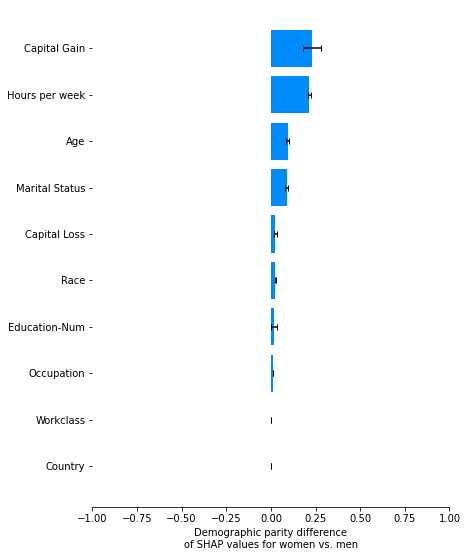

In [360]:
glabel = "Demographic parity difference\nof SHAP values for women vs. men"
xmin = -1
xmax = 1
group_difference(shap_values, 
                 female_indices, male_indices, 
                 train_data.columns,
                 xmin, xmax, glabel,
                 apply_sigmoid=False)